In [1]:
import torch
import math
import mmcv
from mmdet.apis import init_detector
from mmocr.apis.inference import model_inference
from mmocr.core.visualize import det_recog_show_result
from mmocr.datasets.pipelines.crop import crop_img
from mmdet.datasets import replace_ImageToTensor
from mmdet.datasets.pipelines import Compose

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


%matplotlib inline

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


In [2]:
# build recog model
recog_ckpt = "crnn_academic-a723a1c5.pth"
recog_config = "crnn_academic_dataset.py"
device = 'cpu'


In [3]:
recog_model = init_detector(
    recog_config, recog_ckpt, device=device)
if hasattr(recog_model, 'module'):
    recog_model = recog_model.module
# if recog_model.cfg.data.test['type'] == 'ConcatDataset':
#     recog_model.cfg.data.test.pipeline = \
#         recog_model.cfg.data.test['datasets'][0].pipeline

Use load_from_local loader


In [4]:
def preprocess_image(pil_im, dst_height=32, dst_min_width=32, width_downsample_ratio=1.0 / 16):

    (ori_width, ori_height) = pil_im.size
    new_width = math.ceil(float(dst_height) / ori_height * ori_width)
    width_divisor = int(1 / width_downsample_ratio)

    if new_width % width_divisor != 0:
        new_width = round(new_width / width_divisor) * width_divisor
    
    new_width = max(dst_min_width, new_width)
    
    im_resized = pil_im.resize(size=(new_width, dst_height))
    
    return np.asarray(im_resized, dtype=np.float32)

In [5]:
image = "test_images/image_2.jpg"

pil_im = Image.open(image).convert('L')
print(pil_im.size)
im_array = preprocess_image(pil_im)
print(im_array.shape)

im_array = (im_array-127.0)/127.0

image_tensor = torch.from_numpy(im_array)
image_tensor = image_tensor.unsqueeze(0).to(device)

print(image_tensor.shape)

(39, 32)
(32, 32)
torch.Size([1, 32, 32])


In [6]:
data = dict(img=image_tensor.unsqueeze(0), img_metas=[{'filename': 'test_images/image_1.jpg', 'resize_shape': (32, 48), 'valid_ratio': 1.0}])
with torch.no_grad():
    det_result = recog_model(return_loss=False, rescale=True, **data)

[{'text': '29', 'score': [0.7329947352409363, 0.5580153465270996]}]


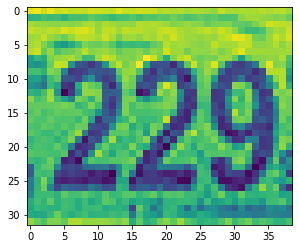

In [7]:
im_array = np.asarray(pil_im)
plt.imshow(im_array)
print(det_result)

# Quantization

In [8]:
from utils import CRNNNet, VeryDeepVgg
from mmocr.models.textrecog import CTCConvertor, CTCLoss, CRNNDecoder
from mmcv.runner import load_checkpoint
import copy

In [9]:
config = mmcv.Config.fromfile(recog_config)
model_config = config.model
# print(model_config)

In [10]:
max_seq_len=40

backbone_cfg = model_config['backbone'].copy()
backbone_cfg.pop('type')
backbone = VeryDeepVgg(**backbone_cfg)


label_converter_cfg = model_config['label_convertor'].copy()
label_converter_cfg.pop('type')
label_converter_cfg.update(max_seq_len=max_seq_len)
label_converter = CTCConvertor(**label_converter_cfg)

decoder_cfg = model_config['decoder'].copy()
decoder_cfg.pop('type')
decoder_cfg.update(num_classes=label_converter.num_classes())
decoder_cfg.update(start_idx=label_converter.start_idx)
decoder_cfg.update(padding_idx=label_converter.padding_idx)
decoder_cfg.update(max_seq_len=max_seq_len)
decoder = CRNNDecoder(**decoder_cfg)


loss_cfg = model_config['decoder'].copy()
loss_cfg.pop('type')
loss_cfg.update(ignore_index=label_converter.padding_idx)
loss = CTCLoss(**loss_cfg)



In [11]:
backbone.load_state_dict(recog_model.backbone.state_dict())
decoder.load_state_dict(recog_model.decoder.state_dict())

model = CRNNNet(preprocessor=None,
            backbone=backbone,
            decoder=decoder,
            loss=loss,
            label_convertor=label_converter,
            pretrained=None,
            test_cfg=config.get('test_cfg'))
# model.backbone.load_state_dict(recog_model.backbone.state_dict())
# model.decoder.load_state_dict(recog_model.decoder.state_dict())
# model.load_state_dict(torch.load(recog_ckpt)['state_dict'])
# map_loc = 'cpu' if device == 'cpu' else None
# checkpoint = load_checkpoint(model, recog_ckpt, map_location=map_loc)
# if 'CLASSES' in checkpoint.get('meta', {}):
#     model.CLASSES = checkpoint['meta']['CLASSES']
# _ = model.to(device)
model.eval()
model.cfg = config

In [13]:
# with torch.no_grad():
det_result = model(return_loss=False, rescale=True, **data)
    
print(det_result)

[{'text': '29', 'score': [0.7329947352409363, 0.5580153465270996]}]


In [ ]:
fuser_list = [
    ["backbone.cnn.conv0", "backbone.cnn.relu0"],
    ["backbone.cnn.conv1", "backbone.cnn.relu1"],
    ["backbone.cnn.conv2", "backbone.cnn.batchnorm2", "backbone.cnn.relu2"],
    ["backbone.cnn.conv3", "backbone.cnn.relu3"],
    ["backbone.cnn.conv4", "backbone.cnn.batchnorm4", "backbone.cnn.relu4"],
    ["backbone.cnn.conv5", "backbone.cnn.relu5"],
    ["backbone.cnn.conv6", "backbone.cnn.batchnorm6", "backbone.cnn.relu6"]
]
fused_model = torch.quantization.fuse_modules(copy.deepcopy(model), fuser_list, inplace=True)
fused_model.eval()

In [ ]:
fused_model

In [ ]:
with torch.no_grad():
    det_result = fused_model(return_loss=False, rescale=True, **data)
    
print(det_result)

In [ ]:


def save_torchscript_model(model, model_dir, model_filename):
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    model_filepath = os.path.join(model_dir, model_filename)
    torch.jit.save(torch.jit.script(model), model_filepath)

def load_torchscript_model(model_filepath, device):
    model = torch.jit.load(model_filepath, map_location=device)
    return model

def calibrate_model(model, device=torch.device("cpu:0")):
    model.to(device)
    model.eval()
    
    for i in range(3):
        _ = model(return_loss=False, rescale=True, **data)
#     for inputs, labels in loader:
#         inputs = inputs.to(device)
#         labels = labels.to(device)
#         _ = model(inputs)

In [ ]:
cpu_device = torch.device("cpu:0")
model_dir = "quantized"
quantized_model_filename = "crnn_quantized_int8.ptl"

image = "test_images/image_2.jpg"

pil_im = Image.open(image).convert('L')
print(pil_im.size)
im_array = preprocess_image(pil_im)
print(im_array.shape)

im_array = (im_array-127.0)/127.0

image_tensor = torch.from_numpy(im_array)
image_tensor = image_tensor.unsqueeze(0).to(cpu_device)
data = dict(img=image_tensor.unsqueeze(0), img_metas=[{'filename': 'test_images/image_1.jpg', 'resize_shape': (32, 48), 'valid_ratio': 1.0}])

In [ ]:
# quantization_config = torch.quantization.get_default_qconfig("fbgemm") # or 'qnnpack'
quantization_config = torch.quantization.get_default_qconfig('qnnpack') # or 'qnnpack'
fused_model.qconfig = quantization_config

print(fused_model.qconfig)

torch.quantization.prepare(fused_model, inplace=True)

calibrate_model(model=fused_model, device=cpu_device)

quantized_model = torch.quantization.convert(fused_model, inplace=True)

quantized_model.eval()

# Print quantized model.
# print(quantized_model)

# Save quantized model.
save_torchscript_model(model=quantized_model, model_dir=model_dir, model_filename=quantized_model_filename)

# Load quantized model.
quantized_jit_model = load_torchscript_model(model_filepath=quantized_model_filepath, device=cpu_device)

In [ ]:
with torch.no_grad():
#     det_result = quantized_jit_model(return_loss=False, rescale=True, **data)
    det_result = quantized_jit_model(return_loss=False, rescale=True, **data)
    
print(det_result)